# Оценка риска ДТП по выбранному маршруту движения

# Содержание

1. [Подключение к базе данных](#1)
2. [Первичное исследование таблиц](#2)
3. [Статистический анализ факторов ДТП](#3)
4. [Создание датафрейма для решения задачи](#4)
5. [Предобработка данных](#5)
6. [Подготовка данных для моделей](#6)
7. [Обучение моделей](#7)
8. [Анализ важности факторов ДТП](#8)
9. [Выводы](#9)

**Цель проекта** - создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. 

Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Задачи от заказчика**: 

- Создать модель предсказания ДТП.
    - Для модели выбрать тип виновника — только машина (car).
    - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
    - Для моделирования ограничиться данными за 2012 год — они самые свежие.
    - Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Ответить на вопросы:
    - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    - Какие ещё факторы нужно учесть?
    - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
    
В распоряжении SQL таблицы, содержащие информацию о происшествиях (collisions), участниках происшествия (parties) и автомобилях (vehicles).

## Импорт библиотек

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna

from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.metrics import recall_score, precision_score

pd.options.mode.chained_assignment = None

In [3]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


## Подключение к базе данных <a id="1"></a>

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

#сторока подключения к базе данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

## Первичное исследование таблиц <a id="2"></a>

In [5]:
sql_query = """
SELECT *
FROM collisions
"""
collisions = pd.read_sql_query(sql_query, con=engine)
print('Первые пять строк таблицы collisions:')
display(collisions.head().sort_values('case_id'))
print('Информация о таблице collisions:')
display(collisions.info())

Первые пять строк таблицы collisions:


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Информация о таблице collisions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_c

None

In [6]:
sql_query = """
SELECT *
FROM parties
"""
parties = pd.read_sql_query(sql_query, con=engine)
print('Первые строки таблицы parties:')
display(parties.head(20))
print('Информация о таблице parties:')
print(parties.info())

Первые строки таблицы parties:


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


Информация о таблице parties:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB
None


In [7]:
sql_query = """
SELECT *
FROM vehicles
"""
vehicles = pd.read_sql_query(sql_query, con=engine)
print('Первые пять строк таблицы vehicles:')
display(vehicles.head())
print('Информация о таблице vehicles:')
print(vehicles.info())

Первые пять строк таблицы vehicles:


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


Информация о таблице vehicles:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB
None


In [8]:
sql_query = """
SELECT *
FROM case_ids
"""
case_ids = pd.read_sql_query(sql_query, con=engine)
print('Первые пять строк таблицы case_ids:')
display(case_ids.head())
print('Информация о таблице case_ids:')
print(case_ids.info())

Первые пять строк таблицы case_ids:


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Информация о таблице case_ids:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB
None


- Все таблицы имеют набор данных;
- Общий ключ для связи таблиц имеется (case_id);
- Таблица case_ids отличается от того, как она описана на схеме данных. В ней 2 столбца:
    - case_id - id проишествия
    - db_year - год происшествия
- Количество таблиц не соответствует условию задачи. Для построения рабочей модели необходимы данные о поездках без ДТП. В данном случае у модели будет 100 процентное смещение в строну предсказания ДТП.


##  Статистический анализ факторов ДТП <a id="3"></a>

Посмотрим, в какие месяцы происходит наибольшее количество аварий за весь период наблюдений.

In [9]:
sql_query = """
SELECT COUNT(case_id) as collision_count, date_trunc('month', collision_date)::date as collision_date
FROM collisions
group by date_trunc('month', collision_date)
"""

collisions_count = pd.read_sql_query(sql_query, con=engine)
collisions_count.head()

,collision_count,collision_date
0,35062,2009-01-01
1,34480,2009-02-01
2,36648,2009-03-01
3,35239,2009-04-01
4,36916,2009-05-01


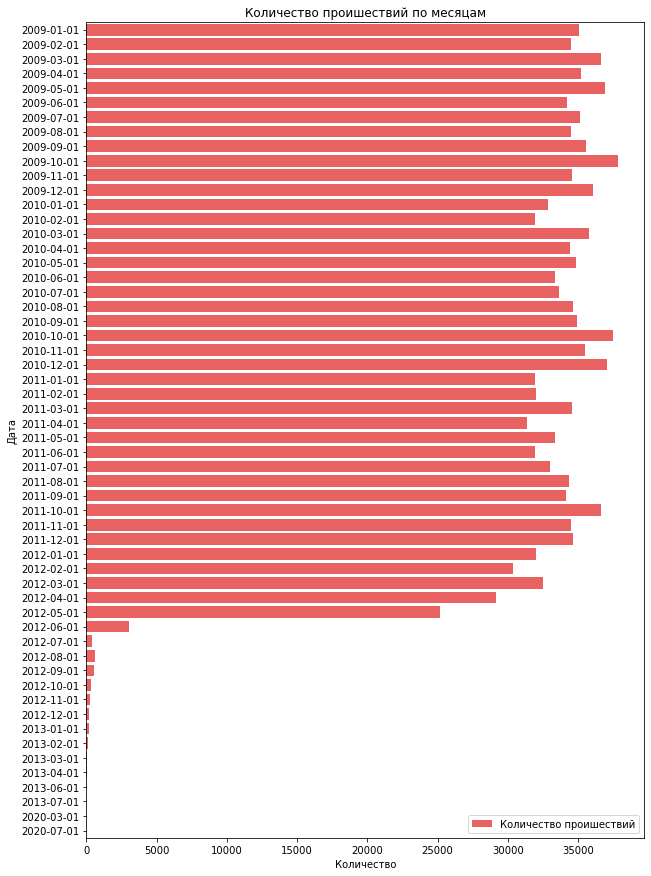

In [10]:
f, ax = plt.subplots(figsize=(10, 15))

sns.barplot(data =collisions_count, 
            x='collision_count',
            y = 'collision_date',
            palette = ['r'],
            alpha=0.7, label = 'Количество проишествий', ax=ax)
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")

plt.title("Количество проишествий по месяцам")
plt.show()

Начиная с января 2012 года происходит резкое падение количества проишествий, которое можно объяснить недостатком данных.

У нас достаточно небольшой период наблюдений, всего 3 года, то есть по три наблюдения на каждый месяц. Обнаруживаются высокие значения в осенние месяцы (сентябрь-октябрь), вероятнее всего это связано с погодными условиями (дожди,туман).

In [11]:
time_series = """

WITH f AS
(SELECT CAST(DATE_TRUNC('MONTH', COLLISION_DATE) as DATE) AS date,
       COUNT(CASE_ID)
FROM collisions
WHERE COLLISION_DATE BETWEEN '2009-01-01' AND '2012-06-01'
GROUP BY CAST(DATE_TRUNC('MONTH', COLLISION_DATE) as DATE))

SELECT EXTRACT(MONTH FROM date) AS accidents_date,
       AVG(count) AS accidents_mean
FROM f
GROUP BY EXTRACT(MONTH FROM date);
"""

time_series = pd.read_sql_query(time_series, con = engine)

month_list = {1 : 'Январь',
              2 : 'Февраль',
              3 : 'Март',
              4 : 'Апрель',
              5 : 'Май',
              6 : 'Июнь',
              7 : 'Июль',
              8 : 'Август',
              9 : 'Сентябрь',
              10 : 'Октябрь',
              11 : 'Ноябрь',
              12 : 'Декабрь'} 


time_series = time_series.sort_values(by='accidents_date').reset_index(drop=True)
time_series['accidents_date'] = time_series['accidents_date'].replace(month_list)
time_series = time_series.set_index('accidents_date')
time_series

,accidents_mean
accidents_date,
Январь,32975.00
Февраль,32187.50
Март,34883.50
Апрель,32543.75
Май,32579.00
Июнь,25005.50
Июль,33945.00
Август,34489.00
Сентябрь,34883.00


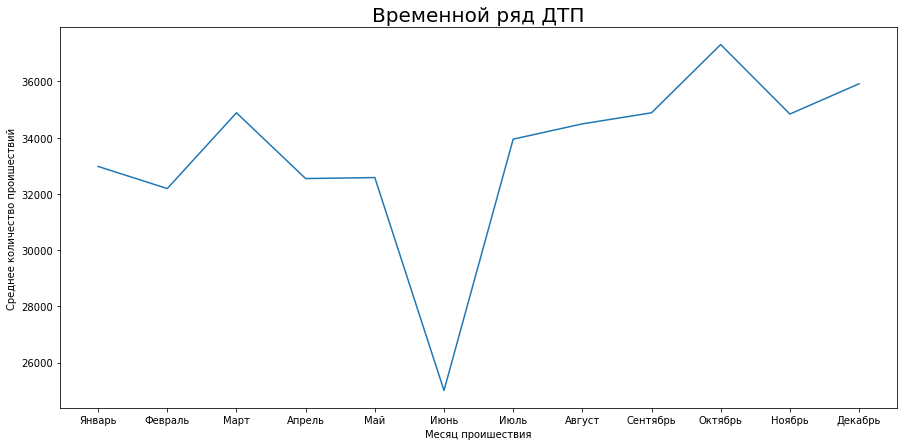

In [12]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(7)
ax.plot(time_series.index, time_series['accidents_mean'])
ax.set_title('Временной ряд ДТП', fontsize=20)
ax.set_xlabel('Месяц проишествия')
ax.set_ylabel('Среднее количество проишествий')
plt.show()

За период 1 января 2009 - 1 июня 2012 отмечается рост дтп в марте и октябре. Меньше всего происшествий в июне. Логично, ведь состояние дорог, видимость и эмоциональное состояние водителей в июне намного больше располагает к безопасному движению. 

Для получения более подробного статистического анализа на совещание рабочей группы выносятся следующие аналитические задачи:

- Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
- Найдите самые частые причины ДТП (таблица parties);
- Выявите, автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП (связать vehicles и collisions);
- Найдите район, в котором произошло больше всего аварий в период с 01.01.2009 по 01.06.2012? (таблица collisions);
- Проанализируйте зависимость серьезности ДТП от погодных факторов (таблица collisions);
- Выявите, влияет ли трезвость участника на тип дополнительных участников дтп (связать parties и collisions);
- Проанализируйте влияние типа местности на тип аварии (таблица collisions);
- Выявите, влияет ли трезвость участника и его состояние на категорию нарушения (связать parties и collisions);
- Проанализируйте влияние типа КПП на виновность участника (связать vehicles и parties). 

In [13]:
sql_query = '''
select distinct road_surface, collision_damage,
COUNT(collision_damage) over (partition by road_surface order by collision_damage) as col_count
from collisions c 
where case_id in (select distinct case_id
                  from parties p 
                  where party_type = 'car')
order by road_surface, col_count'''

col_with_weather = pd.read_sql_query(sql_query, con=engine)
col_with_weather

,road_surface,collision_damage,col_count
0,dry,fatal,9746
1,dry,middle damage,156935
2,dry,scratch,463545
3,dry,severe damage,490510
4,dry,small damage,1232957
5,slippery,fatal,12
6,slippery,middle damage,237
7,slippery,scratch,541
8,slippery,severe damage,601
9,slippery,small damage,1359


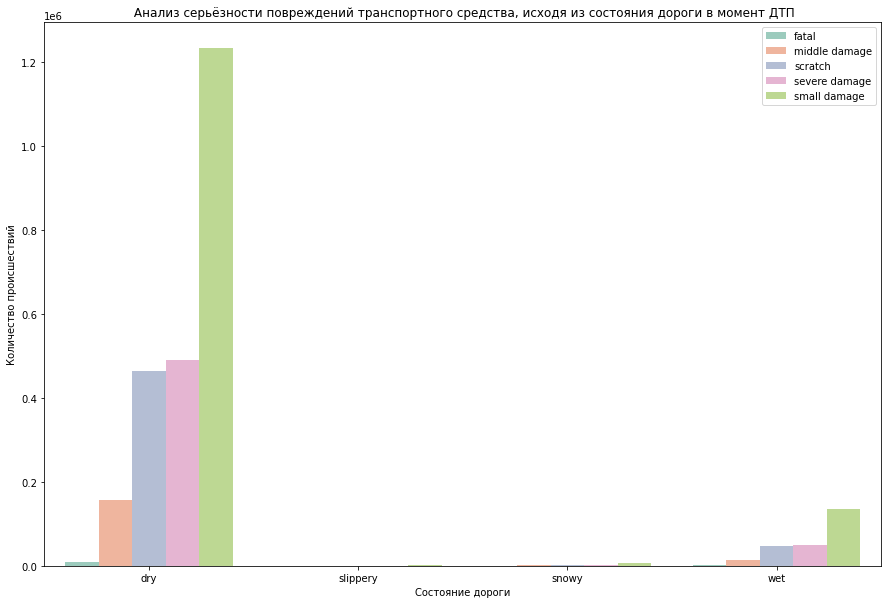

In [14]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(data =col_with_weather, 
            x='road_surface',
            y = 'col_count',
            hue  = 'collision_damage',
            palette = "Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Состояние дороги",
       ylabel="Количество происшествий")

plt.title(" Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП")
plt.show()

Во всех группах состояния дорожного покрытия мы можем заметить крайне схожые паттерны распределения повреждений. И хотя количество проишествий на покрытиях с разным состоянием может отличаться в разы, пропорции очень схожи. Больше всего мелких повреждений, за ними идет серьезное повреждение, потом царапины, среднее повреждение и меньше всего фатальных.

In [15]:
sql_query = '''
select *,
col_count/SUM(col_count) over (partition by vehicle_type) as prcnt
from (
select distinct collision_damage, vehicle_type,
count(collision_damage) over(partition by vehicle_type order by collision_damage) as col_count
from
(select case_id , collision_damage 
from collisions) c 
join
(select case_id, vehicle_type
from vehicles) v  on c.case_id = v.case_id) t
'''

car_crash = pd.read_sql_query(sql_query, con=engine)

car_crash = car_crash.fillna('unknown')
car_crash

,collision_damage,vehicle_type,col_count,prcnt
0,severe damage,coupe,442780,0.437932
1,middle damage,coupe,140402,0.138865
2,scratch,coupe,418973,0.414385
3,fatal,coupe,8916,0.008818
4,severe damage,hatchback,45595,0.420385
5,middle damage,hatchback,20362,0.187737
6,fatal,hatchback,2786,0.025687
7,scratch,hatchback,39717,0.366190
8,middle damage,minivan,22573,0.212981
9,fatal,minivan,527,0.004972


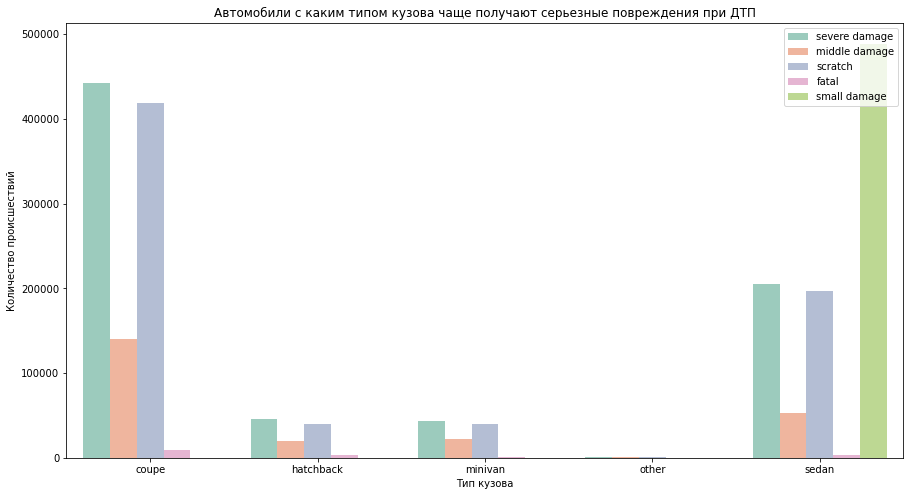

In [16]:
f, ax = plt.subplots(figsize=(15, 8))


sns.barplot(data =car_crash, 
            x='vehicle_type',
            y = 'col_count',
            hue  = 'collision_damage',
            palette = "Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Тип кузова",
       ylabel="Количество происшествий")

plt.title("Автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП")
plt.show()

В количественном отношении во всех категориях кроме легких повреждений лидируют машины с типом кузова купе. Посмотрим в процентном соотношении.

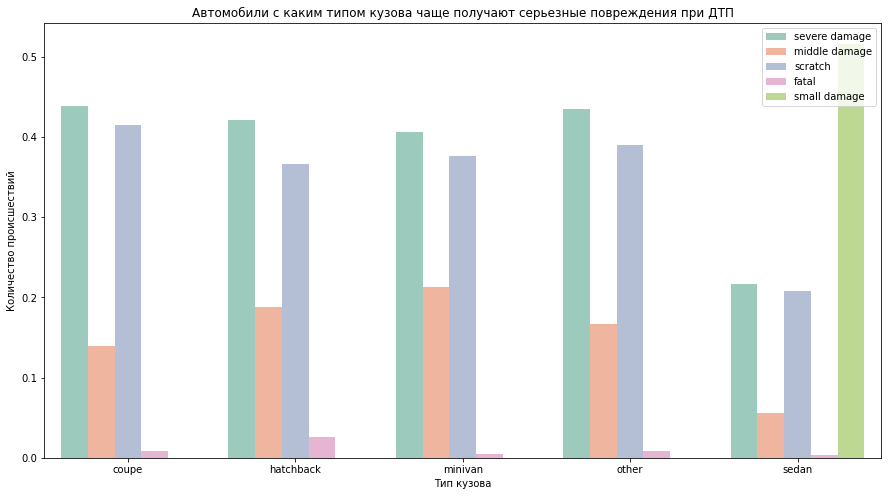

In [17]:
f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data =car_crash, 
            x='vehicle_type',
            y = 'prcnt',
            hue  = 'collision_damage',
            palette = "Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Тип кузова",
       ylabel="Количество происшествий")

plt.title("Автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП")
plt.show()


В категории серьезные повреждения и царапины все еще лидируют Купе. В категории средние повреждения лидируют Минивены, а в категории не подлежит восстановлению - лидер Хачбек. В категории кузова Седан вероятно имеются аномалии и рассматривать ее в данной статистике не представляется возможным.

In [18]:
sql_query = '''

SELECT v.vehicle_age,
       p.at_fault
FROM parties AS p
INNER JOIN vehicles AS v ON p.case_id = v.case_id and p.party_number = v.party_number

'''

vehicle_age = pd.read_sql_query(sql_query, con = engine)

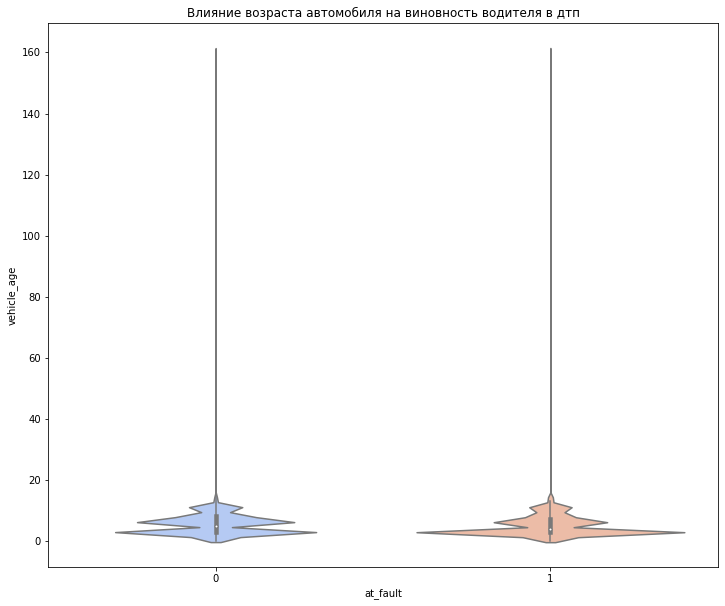

In [19]:
plt.figure(figsize = (12, 10))
sns.violinplot(
    x = vehicle_age.at_fault,
    y = vehicle_age.vehicle_age,
    kind = "violin",
    split = True,
    palette = "coolwarm"
)
plt.title("Влияние возраста автомобиля на виновность водителя в дтп")
plt.show()

**Вывод**: графики возраста автомобиля абсолютно идентичны с двух сторон, этот параметр никак не влияет на виновность человека в проишествии.

## Создание датафрейма для решения задачи <a id="4"></a>

Подготовим предварительный набор данных на основе предположения заказчика.

In [20]:
sql_query = '''

SELECT 
       v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age,
       c.county_city_location,
       c.county_location,
       c.distance,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.collision_damage,
       c.party_count,
       c.primary_collision_factor,
       c.pcf_violation_category,
       c.type_of_collision,
       c.motor_vehicle_involved_with,
       c.road_surface,
       c.road_condition_1,
       c.lighting,
       c.control_device,
       c.collision_date,
       c.collision_time,
       p.party_type,
       p.insurance_premium,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use,
       p.at_fault
FROM case_ids AS ci
INNER JOIN collisions AS c ON ci.CASE_ID = c.CASE_ID
INNER JOIN vehicles AS v ON c.CASE_ID = v.CASE_ID 
INNER JOIN parties AS p ON v.CASE_ID = p.CASE_ID and v.PARTY_NUMBER = p.PARTY_NUMBER
WHERE p.PARTY_TYPE = 'car' AND c.COLLISION_DAMAGE != 'SCRATCH' AND EXTRACT(YEAR FROM c.COLLISION_DATE) = 2012;

'''

df = pd.read_sql_query(sql_query, con=engine)
df.head()

,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,...,lighting,control_device,collision_date,collision_time,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,at_fault
0,sedan,auto,2.0,1942,los angeles,20.0,south,0.0,clear,None,...,daylight,functioning,2012-04-15,17:05:00,car,46.0,had not been drinking,None,0.0,0
1,sedan,auto,10.0,1942,los angeles,450.0,east,0.0,clear,highway,...,daylight,none,2012-04-18,17:15:00,car,52.0,had not been drinking,None,0.0,0
2,sedan,auto,6.0,1900,los angeles,0.0,None,1.0,clear,None,...,daylight,functioning,2012-04-23,09:05:00,car,16.0,had not been drinking,None,0.0,0
3,sedan,auto,11.0,3001,orange,175.0,west,0.0,clear,ramp,...,daylight,functioning,2012-04-29,18:22:00,car,71.0,had not been drinking,None,0.0,0
4,sedan,auto,3.0,3015,orange,113.0,north,0.0,clear,None,...,dark with street lights,functioning,2012-05-17,20:15:00,car,21.0,not applicable,not applicable,0.0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103267 entries, 0 to 103266
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   vehicle_type                 103267 non-null  object 
 1   vehicle_transmission         101309 non-null  object 
 2   vehicle_age                  100606 non-null  float64
 3   county_city_location         103267 non-null  object 
 4   county_location              103267 non-null  object 
 5   distance                     103267 non-null  float64
 6   direction                    75818 non-null   object 
 7   intersection                 102918 non-null  float64
 8   weather_1                    102962 non-null  object 
 9   location_type                43323 non-null   object 
 10  collision_damage             103267 non-null  object 
 11  party_count                  103267 non-null  int64  
 12  primary_collision_factor     102992 non-null  object 
 13 

In [22]:
df.isna().sum()

vehicle_type                       0
vehicle_transmission            1958
vehicle_age                     2661
county_city_location               0
county_location                    0
distance                           0
direction                      27449
intersection                     349
weather_1                        305
location_type                  59944
collision_damage                   0
party_count                        0
primary_collision_factor         275
pcf_violation_category          1481
type_of_collision                595
motor_vehicle_involved_with      341
road_surface                     783
road_condition_1                 545
lighting                         333
control_device                   476
collision_date                     0
collision_time                   110
party_type                         0
insurance_premium                796
party_sobriety                  1594
party_drug_physical            98927
cellphone_in_use               10003
a

In [23]:
df.at_fault.value_counts(normalize = True)

0    0.553294
1    0.446706
Name: at_fault, dtype: float64

- Имеем 26 признаков, at_fault - целевой.
- В большинстве столбцов обнаружены пропуски.
- Присутствует дисбаланс классов. Класса 0 больше чем класса 1, но разница не критична.

## Предобработка данных <a id="5"></a>

Почти каждый признак нуждается в предобработке, рассмотрим их по порядку.

In [24]:
df_orig = df.copy()

In [25]:
df.vehicle_type.value_counts()

sedan    52350
coupe    50895
other       22
Name: vehicle_type, dtype: int64

Other - очень маленькое количество. Вероятно надо его исключить.

In [26]:
df = df.drop(df[df['vehicle_type'] == 'other'].index)
df['vehicle_type'] = df['vehicle_type'].astype('category')

In [27]:
df['collision_time'].head()

0    17:05:00
1    17:15:00
2    09:05:00
3    18:22:00
4    20:15:00
Name: collision_time, dtype: object

Состояние водителя зависит от времени суток, оставим признак, но только часы.

In [28]:
df = df.drop(df[df['collision_time'].isna()].index)
df['collision_time'] = df['collision_time'].apply(lambda x: x.hour)
df['collision_time'].value_counts()

15    9014
17    8265
16    7815
14    7529
18    7176
13    6623
12    6295
8     5388
11    5316
7     5284
19    4504
10    4405
9     4206
20    3589
21    3152
22    2555
6     2229
23    2059
2     1592
1     1584
0     1541
5     1228
3      999
4      787
Name: collision_time, dtype: int64

In [29]:
df['collision_time'] = df['collision_time'].astype('category')

Cтолбец collision_date важен, сложность вождения имеет зависимость от времени года, но в периоде, который мы рассматриваем у нас есть данные только по 5 месяцам. Алгоритм может переобучиться на этих месяцах и другие предсказывать хуже. В таком разрезе столбец нам не подходит, но из него можно извлечь информацию о дне недели. 

In [30]:
df['collision_date'] = df['collision_date'].apply(lambda x: x.weekday())
df['collision_date'].value_counts()

4    17140
5    15435
2    14780
3    14703
1    14524
0    13534
6    13019
Name: collision_date, dtype: int64

In [31]:
df['collision_date'] = df['collision_date'].astype('category')

In [32]:
df['control_device'].value_counts()

none               63814
functioning        38534
not functioning      250
obscured              63
Name: control_device, dtype: int64

not functioning и obscured - очень малое количество. Заменим на значение 'none'.

In [33]:
control_device_map = {
    'not functioning': 'none',
    'obscured':'none'
}

df['control_device'] = df['control_device'].apply(lambda x: control_device_map[x] if x in control_device_map else x)
df['control_device'].value_counts()

none           64127
functioning    38534
Name: control_device, dtype: int64

In [34]:
df = df.drop(df[df['control_device'].isna()].index)
df['control_device'] = df['control_device'].astype('category')

In [35]:
df['lighting'].value_counts()

daylight                                   72091
dark with street lights                    19407
dark with no street lights                  7412
dusk or dawn                                3260
dark with street lights not functioning      220
Name: lighting, dtype: int64

dark with street lights not functioning очень небольшая категория, можно объединить с dark with no street lights. 

In [36]:
df = df.drop(df[df['lighting'].isna()].index)

lighting_map = {
    'dark with street lights not functioning': 'dark with no street lights',
}

df['lighting'] = df['lighting'].apply(lambda x: lighting_map[x] if x in lighting_map else x)
df['lighting'].value_counts()

daylight                      72091
dark with street lights       19407
dark with no street lights     7632
dusk or dawn                   3260
Name: lighting, dtype: int64

In [37]:
df['lighting'] = df['lighting'].astype('category')

In [38]:
df['road_condition_1'].value_counts()

normal            98762
construction       1696
holes               475
obstruction         374
other               338
loose material      185
reduced width       103
flooded              59
Name: road_condition_1, dtype: int64

В категориях кроме normal мало значений, однако все они свидетельствуют о проблемах, поэтому объединим их в одну.

In [39]:
df = df.drop(df[df['road_condition_1'].isna()].index)

road_condition_map = {
    'construction': 'probem',
    'holes': 'probem',
    'obstruction': 'probem',
    'other': 'probem',
    'loose material': 'probem',
    'reduced width': 'probem',
    'flooded': 'probem'
}

df['road_condition_1'] = df['road_condition_1'].apply(lambda x: road_condition_map[x] if x in road_condition_map else x)
df['road_condition_1'].value_counts()

normal    98762
probem     3230
Name: road_condition_1, dtype: int64

In [40]:
df['road_condition_1'] = df['road_condition_1'].astype('category')

In [41]:
df['road_surface'].value_counts()

dry         90977
wet          9824
snowy         520
slippery       67
Name: road_surface, dtype: int64

Категорию slippery объединим со snowy, обе подразумевают скользкую дорогу.

In [42]:
df = df.drop(df[df['road_surface'].isna()].index)

road_surface_map = {
    'slippery': 'snowy'
}

df['road_surface'] = df['road_surface'].apply(lambda x: road_surface_map[x] if x in road_surface_map else x)
df['road_surface'].value_counts()

dry      90977
wet       9824
snowy      587
Name: road_surface, dtype: int64

In [43]:
df['road_surface'] = df['road_surface'].astype('category')

In [44]:
df['motor_vehicle_involved_with'].value_counts()

other motor vehicle               79940
fixed object                      11890
non-collision                      3154
other object                       2203
parked motor vehicle               2117
motor vehicle on other roadway      884
bicycle                             663
animal                              263
train                                25
Name: motor_vehicle_involved_with, dtype: int64

In [45]:
df['type_of_collision'].value_counts()

rear end      40240
broadside     24301
sideswipe     13046
hit object    12197
head-on        5677
overturned     3164
other          2323
Name: type_of_collision, dtype: int64

Пока оставим эти признаки как есть, только удалим пропуски и заменим тип данных.

In [46]:
df = df.drop(df[df['motor_vehicle_involved_with'].isna()].index)
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].astype('category')

In [47]:
df = df.drop(df[df['type_of_collision'].isna()].index)
df['type_of_collision'] = df['type_of_collision'].astype('category')

In [48]:
df['primary_collision_factor'].value_counts()

vehicle code violation    97062
other than driver          1562
unknown                    1502
other improper driving      352
fell asleep                   3
Name: primary_collision_factor, dtype: int64

In [49]:
df['pcf_violation_category'].value_counts()

speeding                             37035
automobile right of way              14709
improper turning                     12726
dui                                   8148
traffic signals and signs             7455
unsafe lane change                    6685
following too closely                 2563
unsafe starting or backing            2321
wrong side of road                    1985
unknown                               1594
other than driver (or pedestrian)     1562
other hazardous violation              729
improper passing                       674
pedestrian violation                   381
other improper driving                 352
pedestrian right of way                190
other equipment                         99
impeding traffic                        62
hazardous parking                       44
brakes                                  17
lights                                   6
fell asleep                              3
Name: pcf_violation_category, dtype: int64

primary_collision_factor (основной фактор аварии) и pcf_violation_category (категория нарушения) похожи. pcf_violation_category -  более информативный признак, оставим только его, перенеся малочисленные категории в other improper driving.

In [50]:
df = df.drop(df[df['pcf_violation_category'].isna()].index)

pcf_violation_category_map = {
    'fell asleep': 'other improper driving',
    'lights': 'other improper driving',
    'hazardous parking': 'other improper driving',
    'impeding traffic': 'other improper driving',
    'brakes': 'other improper driving'
}

df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: pcf_violation_category_map[x] if x in pcf_violation_category_map else x)

df = df.drop('primary_collision_factor', axis = 1)

df['pcf_violation_category'] = df['pcf_violation_category'].astype('category')
df['pcf_violation_category'].value_counts()

speeding                             37035
automobile right of way              14709
improper turning                     12726
dui                                   8148
traffic signals and signs             7455
unsafe lane change                    6685
following too closely                 2563
unsafe starting or backing            2321
wrong side of road                    1985
unknown                               1594
other than driver (or pedestrian)     1562
other hazardous violation              729
improper passing                       674
other improper driving                 484
pedestrian violation                   381
pedestrian right of way                190
other equipment                         99
Name: pcf_violation_category, dtype: int64

In [51]:
df['party_count'].value_counts()

2     64051
3     15613
1     13973
4      4192
5      1072
6       295
7        89
8        28
9        23
10        4
Name: party_count, dtype: int64

Для определения виновности имеет значение количество участников. Объединим все, что больше одного в одну категорию.

In [52]:
df['party_count'] = df['party_count'].apply(lambda x: 1 if x == 1 else 2 )
df['party_count'] = df['party_count'].astype('category')
df['party_count'].value_counts()

2    85367
1    13973
Name: party_count, dtype: int64

collision_damage - ущерб при аварии, который не влияет на виновность участника ДТП. Удалим столбец.

In [53]:
df = df.drop('collision_damage', axis = 1)

In [54]:
df['location_type'].value_counts()

highway         34580
ramp             5534
intersection     2240
Name: location_type, dtype: int64

Оставим, заполним пропуски.

In [55]:
df['location_type'] = df['location_type'].fillna('other')

df['location_type'] = df['location_type'].astype('category')
df['location_type'].value_counts()

other           56986
highway         34580
ramp             5534
intersection     2240
Name: location_type, dtype: int64

In [56]:
df['weather_1'].value_counts()

clear      79387
cloudy     15053
raining     4123
fog          311
snowing      227
other         61
wind          29
Name: weather_1, dtype: int64

wind объединим с other. Пропуски заполним other.

In [57]:
df['weather_1'] = df['weather_1'].fillna('other')

weather_map = {
    'wind': 'other'
}

df['weather_1'] = df['weather_1'].apply(lambda x: weather_map[x] if x in weather_map else x)


df['weather_1'] = df['weather_1'].astype('category')
df['weather_1'].value_counts()

clear      79387
cloudy     15053
raining     4123
fog          311
other        239
snowing      227
Name: weather_1, dtype: int64

Перекресток является фактором, повышающим вероятность аварии, но не влияет на вероятность быть в ней виновным. Удалим.

In [58]:
df = df.drop('intersection', axis = 1)

In [59]:
df['direction'].value_counts()

north    20364
south    20095
west     16460
east     16397
Name: direction, dtype: int64

Заполним пропуски.

In [60]:
df['direction'] = df['direction'].fillna('unknown')
df['direction'] = df['direction'].astype('category')
df['direction'].value_counts()

unknown    26024
north      20364
south      20095
west       16460
east       16397
Name: direction, dtype: int64

Виновность водителя мало зависит от географического положения автомобиля, удалим столбцы:

In [61]:
df = df.drop('distance', axis = 1)
df = df.drop('county_location', axis = 1)
df = df.drop('county_city_location', axis = 1)

In [62]:
df['cellphone_in_use'].value_counts()

0.0    88484
1.0     1851
Name: cellphone_in_use, dtype: int64

Пропусков около 10000, заполним рандомно.

In [63]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(np.random.choice(df["cellphone_in_use"].dropna()))
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int')
df['cellphone_in_use'] = df['cellphone_in_use'].astype('category')

In [64]:
df['party_drug_physical'].value_counts()

G                        1679
under drug influence     1006
sleepy/fatigued           637
not applicable            551
impairment - physical     196
Name: party_drug_physical, dtype: int64

Заполним пропуски значением G-Impairment Unknown.

In [65]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('impairment unknown')

party_drug_physical_map = {
    'G': 'impairment unknown'
}

df['party_drug_physical'] = df['party_drug_physical'].apply(lambda x: party_drug_physical_map[x] if x in party_drug_physical_map else x)


df['party_drug_physical'] = df['party_drug_physical'].astype('category')
df['party_drug_physical'].value_counts()

impairment unknown       96950
under drug influence      1006
sleepy/fatigued            637
not applicable             551
impairment - physical      196
Name: party_drug_physical, dtype: int64

In [66]:
df['party_sobriety'].value_counts()

had not been drinking                     89308
had been drinking, under influence         5329
impairment unknown                         1679
had been drinking, not under influence      781
not applicable                              551
had been drinking, impairment unknown       307
Name: party_sobriety, dtype: int64

Пропуски заполним значением impairment unknown.

In [67]:
df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')
df['party_sobriety'] = df['party_sobriety'].astype('category')
df['party_sobriety'].value_counts()

had not been drinking                     89308
had been drinking, under influence         5329
impairment unknown                         3064
had been drinking, not under influence      781
not applicable                              551
had been drinking, impairment unknown       307
Name: party_sobriety, dtype: int64

In [68]:
df['insurance_premium'].describe()

count    98600.000000
mean        38.689828
std         16.273282
min          0.000000
25%         25.000000
50%         36.000000
75%         50.000000
max        105.000000
Name: insurance_premium, dtype: float64

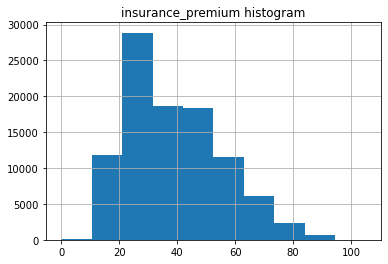

In [69]:
df['insurance_premium'].hist()
plt.title('insurance_premium histogram')
plt.show()


Может влиять на поведение водителя. Полное покрытие страховкой может делать водителя более рисковым и наоборот. Пропуски заполним средним.

In [70]:
df['insurance_premium'] = df['insurance_premium'].fillna(df['insurance_premium'].mean())

In [71]:
df = df.drop('party_type', axis = 1)

In [72]:
df['vehicle_age'].describe()

count    96839.000000
mean         5.216194
std          3.126632
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

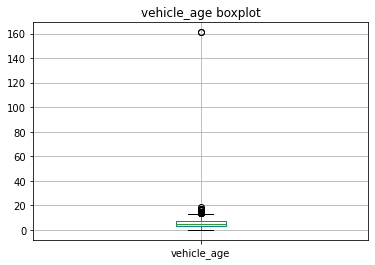

In [73]:
df.boxplot(column = 'vehicle_age')
plt.title('vehicle_age boxplot')
plt.show()

Пропуски заполним медианным значением по столбцу. Все значения старше 12 заменим на 12.

In [74]:
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 12 if x>12 else x)
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())

In [75]:
df['vehicle_age'].describe()

count    99340.000000
mean         5.186732
std          2.953220
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         12.000000
Name: vehicle_age, dtype: float64

In [76]:
df['vehicle_age'] = df['vehicle_age'].astype('int')
df['vehicle_age'] = df['vehicle_age'].astype('category')

In [77]:
df = df.drop('vehicle_transmission', axis = 1)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 0 to 103266
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   vehicle_type                 99340 non-null  category
 1   vehicle_age                  99340 non-null  category
 2   direction                    99340 non-null  category
 3   weather_1                    99340 non-null  category
 4   location_type                99340 non-null  category
 5   party_count                  99340 non-null  category
 6   pcf_violation_category       99340 non-null  category
 7   type_of_collision            99340 non-null  category
 8   motor_vehicle_involved_with  99340 non-null  category
 9   road_surface                 99340 non-null  category
 10  road_condition_1             99340 non-null  category
 11  lighting                     99340 non-null  category
 12  control_device               99340 non-null  category
 13  

In [79]:
df.duplicated().sum() 

1136

In [80]:
df = df.drop_duplicates()
df.duplicated().sum() 

0

In [81]:
len(df)/len(df_orig)

0.9509717528348843

Дубликатов и пропусков нет, данные обработаны и готовы к построению моделей.

Оставили следующий набор признаков:

- vehicle_type - тип кузова. Аварийность зависит от паттернов поведения водителя, люди предпочитающие скорость - выбирают купе, а семейные, предпочитающие вместительность, чаще выбирают minivan.
- collision_time - время проишествия. От вермени суток аварийность зависит.
- collision_date - дата проишествия. Возможно и от дня недели зависит (в пт-сб больше водителей в состоянии опьянения, например)
- control_device - устройство управления. Может зависеть.
- direction - направление движения. Зная о времени движения дает информацию о том, куда светит солнце и не затрудняет ли движение.
- motor_vehicle_involved_with - объект, с которым произошло ДТП. зависимость виновности в ДТП от объекта, с которым произошло столкновение может существовать. Наличие пешехода, велосипедистов, животных на дороге часто приводит к дтп.
- insurance_premium - страховая премия. Без сомнений можно было бы оставить признак, имея данные просто о наличии страхования, а не факте выплаты. Полное покрытие страховкой может делать водителя более рисковым и наоборот. Но предлагаю все-таки оставить признак.
- vehicle_age - возраст машины. Обязательный признак в задаче заказчика.

Признаки ниже очевидно влияют на дтп:
- lighting - освещенность.
- road_condition_1 - состояние улицы.
- road_surface - состояние покрытия.
- party_count - количество участников. 
- location_type - тип дороги. 
- weather_1 - погода. 
- intersection - перекресток.
- cellphone_in_use - наличие телефона в машине.
- party_sobriety - трезвость участника.
- party_drug_physical - состояние участника. 



In [82]:
df = df.drop('type_of_collision', axis = 1)
df = df.drop('pcf_violation_category', axis = 1)
df = df.drop('party_count', axis = 1)


## Подготовка данных для моделей <a id="6"></a>

Разделим данные на категориальные, числовые и целевой признак.

In [83]:
target = ['at_fault']
numeric = ['insurance_premium']
category = list(set(df.columns) - set(numeric) - set(target))
category, numeric

(['lighting',
  'party_sobriety',
  'collision_date',
  'control_device',
  'vehicle_age',
  'cellphone_in_use',
  'collision_time',
  'road_surface',
  'motor_vehicle_involved_with',
  'direction',
  'party_drug_physical',
  'location_type',
  'weather_1',
  'road_condition_1',
  'vehicle_type'],
 ['insurance_premium'])

Проведем разделение на тренировочную, валидационную и тестовую выборки, масштабирование и кодирование.

In [84]:
X = df.drop(target, axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

X_train_c = X_train.copy()
X_val_c = X_val.copy()
X_test_c = X_test.copy()


enc = OneHotEncoder(handle_unknown='error', sparse = 'False', drop='first')
enc.fit(X_train[category])
X_train_cat =pd.DataFrame(enc.transform(X_train[category]).toarray(), index = X_train.index)
X_val_cat =pd.DataFrame(enc.transform(X_val[category]).toarray(), index = X_val.index)
X_test_cat =pd.DataFrame(enc.transform(X_test[category]).toarray(), index = X_test.index)


X_train =  X_train.drop(category, axis = 1).join(X_train_cat)
X_val = X_val.drop(category, axis = 1).join(X_val_cat)
X_test = X_test.drop(category, axis = 1).join(X_test_cat)



print('X - Train size:', X_train.shape)
print('X - Val size:', X_val.shape)
print('X - Test size:', X_test.shape)

X - Train size: (58922, 80)
X - Val size: (19641, 80)
X - Test size: (19641, 80)


## Обучение моделей <a id="7"></a>

### LogisticRegression

Нам нужно оценить качество упорядочивания алгоритмом объектов двух классов, лучше всего для сравнения моделей подойдет метрика roc-auc.

In [85]:
lr_model = LogisticRegression(C = 0.5, random_state=42, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 1000)
lr_model.fit(X_train, y_train.values.ravel())
lr_model.predict_proba(X_val)[:,1]
roc_auc_score(y_val.values.ravel(), lr_model.predict_proba(X_val)[:,1])


0.7472483613813351

Для старта неплохо, подберем параметры.

In [86]:
def objective_lr(trial):

    param = {     
        'C' : trial.suggest_float("C", 0.1, 100, log=True),
        'penalty' : trial.suggest_categorical('penalty', ["l1", "l2"]),
        'max_iter' : trial.suggest_int('max_iter', 100, 1000, log=True),
    }

    model = LogisticRegression(random_state=42, class_weight = 'balanced', solver = 'liblinear', **param)
    model.fit(X_train, y_train.values.ravel())

    accuracy = roc_auc_score(y_val.values.ravel(), model.predict_proba(X_val)[:, 1])

    return accuracy
    

In [87]:
%%time
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100, timeout=600, n_jobs=-1)


[I 2023-08-03 21:30:46,073] A new study created in memory with name: no-name-bb801b54-c478-4a1c-be9d-463a9079441b
[I 2023-08-03 21:30:50,731] Trial 2 finished with value: 0.7470207898354158 and parameters: {'C': 0.22623812526688086, 'penalty': 'l2', 'max_iter': 268}. Best is trial 2 with value: 0.7470207898354158.
[I 2023-08-03 21:30:52,373] Trial 3 finished with value: 0.7472354405088835 and parameters: {'C': 1.4245085195623097, 'penalty': 'l2', 'max_iter': 681}. Best is trial 3 with value: 0.7472354405088835.
[I 2023-08-03 21:30:54,687] Trial 1 finished with value: 0.7472152460898596 and parameters: {'C': 60.744927831230335, 'penalty': 'l2', 'max_iter': 150}. Best is trial 3 with value: 0.7472354405088835.
[I 2023-08-03 21:30:54,972] Trial 5 finished with value: 0.7472138760904333 and parameters: {'C': 15.680960126545568, 'penalty': 'l2', 'max_iter': 133}. Best is trial 3 with value: 0.7472354405088835.
[I 2023-08-03 21:31:03,345] Trial 10 finished with value: 0.7472157376163713 and 

Wall time: 7min 31s


In [88]:
best_params_lr = study_lr.best_trial.params
best_params_lr


{'C': 0.7960008766167348, 'penalty': 'l2', 'max_iter': 992}

In [89]:
model = LogisticRegression(random_state=42,
                           class_weight = 'balanced',
                           solver = 'liblinear',
                           **best_params_lr)
model.fit(X_train, y_train.values.ravel())

roc_auc_score(y_val.values.ravel(), model.predict_proba(X_val)[:, 1])


0.7472524556925975

Результат совсем немного улучшился, но в целом неплохой.

### LGBMClassifier

In [90]:
def objective_lgbm(trial):

    param = {     
        'max_depth' : trial.suggest_int("max_depth", 3, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True),
        'num_leaves' : trial.suggest_int("num_leaves", 3, 20)
        ###
    }

    model = lgb.LGBMClassifier(n_jobs=-1, random_state = 42,  **param)
    model.fit(X_train_c, y_train.values.ravel())

    accuracy = roc_auc_score(y_val.values.ravel(), model.predict_proba(X_val_c)[:, 1])

    return accuracy
   

In [91]:
%%time
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=500, timeout=600, n_jobs=-1)


[I 2023-08-03 21:38:19,758] A new study created in memory with name: no-name-65e70532-15ba-428a-82a7-021de9c83e81
[I 2023-08-03 21:38:29,811] Trial 5 finished with value: 0.7374143590873912 and parameters: {'max_depth': 7, 'n_estimators': 618, 'learning_rate': 0.36133182929180563, 'num_leaves': 10}. Best is trial 5 with value: 0.7374143590873912.
[I 2023-08-03 21:38:32,367] Trial 7 finished with value: 0.7418860529017643 and parameters: {'max_depth': 3, 'n_estimators': 1022, 'learning_rate': 0.28781117713691745, 'num_leaves': 13}. Best is trial 7 with value: 0.7418860529017643.
[I 2023-08-03 21:38:33,336] Trial 4 finished with value: 0.7576770636934067 and parameters: {'max_depth': 10, 'n_estimators': 925, 'learning_rate': 0.037786310526305524, 'num_leaves': 6}. Best is trial 4 with value: 0.7576770636934067.
[I 2023-08-03 21:38:36,450] Trial 3 finished with value: 0.7560401444552496 and parameters: {'max_depth': 5, 'n_estimators': 1087, 'learning_rate': 0.044779018046302764, 'num_leav

Wall time: 10min 11s


In [92]:
best_params_lgbm = study_lgbm.best_trial.params
best_params_lgbm


{'max_depth': 5,
 'n_estimators': 527,
 'learning_rate': 0.02179153084057909,
 'num_leaves': 13}

In [93]:
%%time
model_lgb = lgb.LGBMClassifier(n_jobs=-1, random_state = 42,  **best_params_lgbm)
model_lgb.fit(X_train_c, y_train.values.ravel())
roc_auc_score(y_val.values.ravel(), model_lgb.predict_proba(X_val_c)[:, 1])


Wall time: 1.79 s


0.7594577910392792

### CatBoostClassifier

In [94]:
def objective(trial):

    param = {     
        'depth' : trial.suggest_int("depth", 3, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True)
        ###
    }

    model = CatBoostClassifier(cat_features=category, early_stopping_rounds = 100, loss_function= 'Logloss', random_state = 42,  **param)
    model.fit(X_train_c, y_train, eval_set=[(X_val_c, y_val)], verbose=0)

    accuracy = roc_auc_score(y_val, model.predict_proba(X_val_c)[:, 1])

    return accuracy

In [95]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500, timeout=600, n_jobs=-1)

[I 2023-08-03 21:48:33,091] A new study created in memory with name: no-name-166e4b0a-f90e-413a-b09d-a36cabbd911b
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2023-08-03 21:50:40,035] Trial 0 finished with value: 0.7580874726436737 and parameters: {'depth': 7, 'n_estimators': 1129, 'learning_rate': 0.2712684446626827}. Best is trial 0 with value: 0.758087472643

Wall time: 19min 51s


In [96]:
best_params = study.best_trial.params
best_params

{'depth': 6, 'n_estimators': 893, 'learning_rate': 0.03785602823954112}

In [97]:
%%time
model = CatBoostClassifier(cat_features=category, 
                           early_stopping_rounds = 100, 
                           loss_function= 'Logloss', 
                           random_state = 42,
                           ** best_params                           
                          )
model.fit(X_train_c, y_train, eval_set=[(X_val_c, y_val)], verbose=3)
roc_auc_score(y_val, model.predict_proba(X_val_c)[:, 1])

0:	learn: 0.6829404	test: 0.6828893	best: 0.6828893 (0)	total: 157ms	remaining: 2m 20s
3:	learn: 0.6562674	test: 0.6562462	best: 0.6562462 (3)	total: 527ms	remaining: 1m 57s
6:	learn: 0.6369330	test: 0.6369807	best: 0.6369807 (6)	total: 1.01s	remaining: 2m 7s
9:	learn: 0.6218734	test: 0.6220992	best: 0.6220992 (9)	total: 1.4s	remaining: 2m 3s
12:	learn: 0.6100124	test: 0.6103011	best: 0.6103011 (12)	total: 1.75s	remaining: 1m 58s
15:	learn: 0.6006087	test: 0.6011418	best: 0.6011418 (15)	total: 2.2s	remaining: 2m
18:	learn: 0.5931590	test: 0.5936184	best: 0.5936184 (18)	total: 2.58s	remaining: 1m 58s
21:	learn: 0.5872350	test: 0.5878444	best: 0.5878444 (21)	total: 3.02s	remaining: 1m 59s
24:	learn: 0.5826577	test: 0.5833633	best: 0.5833633 (24)	total: 3.46s	remaining: 2m
27:	learn: 0.5791589	test: 0.5799080	best: 0.5799080 (27)	total: 3.89s	remaining: 2m
30:	learn: 0.5762294	test: 0.5769965	best: 0.5769965 (30)	total: 4.3s	remaining: 1m 59s
33:	learn: 0.5737788	test: 0.5746212	best: 0.5

0.7597651519792654

Модель CatBoostClassifier обучается медленее, чем LGBMClassifier, но она показала себя намного лучше предыдущих моделей. Остановим свой выбор на ней и проверим на тестовой выборке.

In [98]:
%%time
roc_auc_score(y_test, model.predict_proba(X_test_c)[:, 1])

Wall time: 125 ms


0.755172876911991

Неплохой результат.

0.755172876911991
Threshold value is: 0.46031098435493123


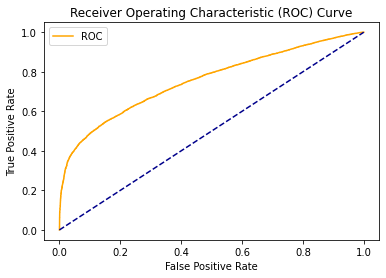

In [99]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_c)[:, 1])
print(roc_auc_score(y_test, model.predict_proba(X_test_c)[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [100]:
cm = confusion_matrix(y_test, model.predict_proba(X_test_c)[:, 1]>=optimal_threshold)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[9219 1632]
 [3989 4801]]

True Positives(TP) =  9219

True Negatives(TN) =  4801

False Positives(FP) =  1632

False Negatives(FN) =  3989


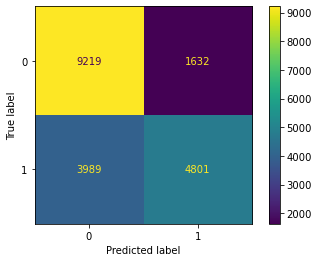

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

Модель достаточно хорошо предсказывает как Positive, так и Negative. Ошибки есть, они смещены в сторону излишненго прогноза Negative.

Recall 0.546188850967008
Precision 0.7463080988652262


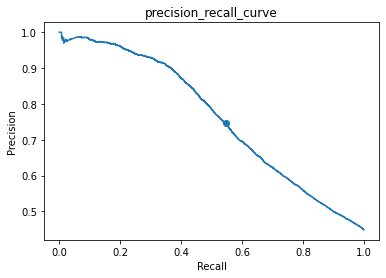

In [102]:
print('Recall', recall_score(y_test, model.predict_proba(X_test_c)[:, 1]>=optimal_threshold))
print('Precision', precision_score(y_test, model.predict_proba(X_test_c)[:, 1]>=optimal_threshold))

precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_c)[:, 1])

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(recall_score(y_test, model.predict_proba(X_test_c)[:, 1]>=optimal_threshold), 
            precision_score(y_test, model.predict_proba(X_test_c)[:, 1]>=optimal_threshold))
plt.title("precision_recall_curve")
plt.show()

## Анализ важности факторов ДТП <a id="8"></a>

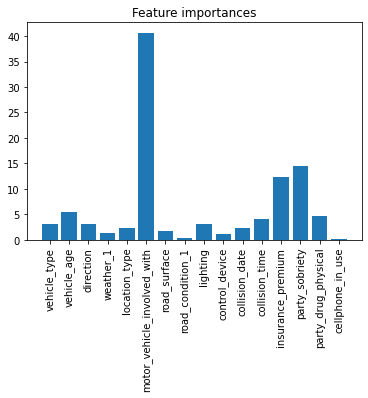

In [103]:
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation = 90) 
plt.title('Feature importances')
plt.show()

In [104]:
sorted(list(zip(model.feature_importances_, X.columns)))

[(0.11389473737743429, 'cellphone_in_use'),
 (0.3045974254349513, 'road_condition_1'),
 (1.168586280419138, 'control_device'),
 (1.2641156528801791, 'weather_1'),
 (1.7260498252775323, 'road_surface'),
 (2.2259961595546645, 'collision_date'),
 (2.313908424332371, 'location_type'),
 (3.004514099337789, 'direction'),
 (3.0512678802364794, 'vehicle_type'),
 (3.095513801929427, 'lighting'),
 (4.106011234431226, 'collision_time'),
 (4.720083798502882, 'party_drug_physical'),
 (5.55365088560665, 'vehicle_age'),
 (12.301559882602223, 'insurance_premium'),
 (14.398105256858756, 'party_sobriety'),
 (40.652144655218336, 'motor_vehicle_involved_with')]

Можно увидеть, что модель определила как самые важные 'insurance_premium', 'party_sobriety', 'party_count', 'collision_time'. Рассмотрим подробнее 'party_sobriety'

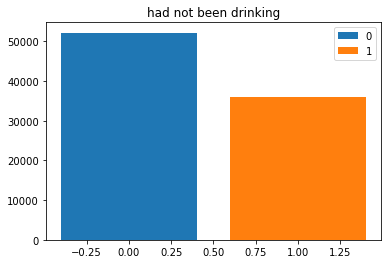

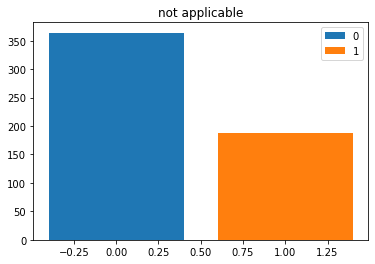

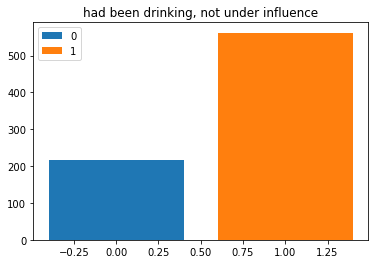

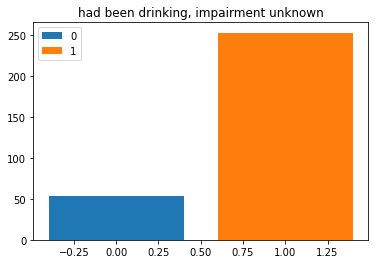

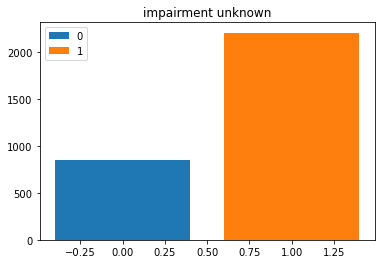

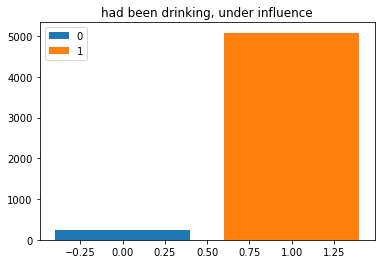

In [105]:
for item in df['party_sobriety'].unique():
    zeros = df.query("party_sobriety==@item")['at_fault'].value_counts()[0]
    if len(df.query("party_sobriety==@item")['at_fault'].value_counts())<2:
        ones = 0
    else:
        ones = df.query("party_sobriety==@item")['at_fault'].value_counts()[1]
    plt.bar(0, zeros, label ='0')
    plt.bar(1, ones, label ='1')
    plt.title(item)
    plt.legend()
    plt.show()

Даже визуально можно заметить что при некоторых значениях данного столбца можно с точностью близкой к 100 процентам определить значение таргета. Например при значении "had been drinking" - почти сто процентов водителей виновны в ДТП.

## Выводы <a id="9"></a>

Если рассматривать таргет, который предложил заказчик, то по нему мы можем предсказать, виновен ли водитель в ДТП. Была построена модель CatBoostClassifier, показавшая себя лучше двух других моделей со значением roc_auc 0.884. Модель определила признаки 'pcf_violation_category', 'insurance_premium', 'collision_time', 'party_count', 'vehicle_age' как самые важные.

Что касается главной цели проекта - построение системы оценки риска попасть в ДТП - на основании предоставленных данных это невозможно. Данные отображают только одну категорию - "Водители, попавшие в ДТП". Модель можно создать, расширив базу данных. Например, собрать данные об успешных поездках (без дтп), сохраняя все учтенные признаки. Также можно добавить данные о наличии страховки, объектах на дороге (пешеход, животные, парковка), наличие участков со статистически большим количество нарушений (например, сплошная полоса на много километров, которую водители часто пересекают, не имея времени доехать до ее конца).